<h1> Using MOMENT for Unsupervised Representation Learning</h1>
<hr>

## Contents
### 1. A Quick Introduction to Representation Learning
### 2. Loading MOMENT
### 3. Getting Representations
### 4. What is MOMENT learning?
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Results Interpretation

## 1. A Quick Introduction to Representation Learning


Learning universal representation for time series is an important and challenging problem. In this tutorial, we will show you how you can use MOMENT to get useful embeddings from time series data. 

Mathematically, our the unsupervised representation learning problem is as follows:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), the representation learning problem involves learning representations that effectively capture the temporal dynamics of time series data. 

In this tutorial, we will learn these representations without any labeled data (unsupervised representation learning). We will also learn instance-level representations i.e. learn a fixed-dimensional representation for a time series sequence, instead of learning representation for each individual time step. 

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model. 

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding` model, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `classification.ipynb` notebook for more details! 

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
# !pip install numpy pandas scikit-learn matplotlib tqdm
# !pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

In [2]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={'task_name': 'embedding'}, # We are loading the model in `embedding` mode to learn representations
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [4]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


## 3. Getting Representations

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs: 
1. An input time series of length $T=512$ timesteps and $C$ channels, and 
2. Two optional masks, both of length $T=512$. 
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.  
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our [paper](https://arxiv.org/abs/2402.03885)). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a representation learning task, it returns `embeddings` of the input. 

Getting representations using MOMENT is one simple forward pass away!

In [5]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1181: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/torch/utils/checkpoint.py:232: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  check_backward_validity(args)


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embeddings=tensor([[-0.0781,  0.0393, -0.0172,  ...,  0.0418, -0.0270, -0.0794],
        [-0.0751,  0.0228, -0.0487,  ..., -0.0191,  0.0453,  0.0002],
        [-0.1042,  0.0300, -0.0269,  ..., -0.0064,  0.0040, -0.0284],
        ...,
        [-0.0749,  0.0459, -0.0283,  ..., -0.0057,  0.0423,  0.0053],
        [-0.0886,  0.0302, -0.0207,  ...,  0.0894, -0.0088, -0.0355],
        [-0.0569,  0.0327, -0.0448,  ..., -0.0248,  0.0400,  0.0416]]),
                  metadata='mean',
      

## 4. What is MOMENT Learning?
In our [paper](https://arxiv.org/abs/2402.03885), we found that MOMENT can capture changes in intutive time series characteristics such as trend, amplitude, frequencies and pases of time series. 

In this tutorial, we will reproduce one of these experiments, and visualize the representations that MOMENT learns as we vary the frequency of synthetically generated sine waves.

We will use the `SyntheticDataset` class to generate 1024 sine waves with frequencies ranging from 1 to 32. 

The data generating process is: $$y = \sin(2c \pi x) + \epsilon,$$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ is normally distributed noise, and the parameter $c \in [1, 32)$ controls the frequency of the sine wave.

In [6]:
from momentfm.data.synthetic_data import SyntheticDataset

synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=1,
    freq_range=(1, 32), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_freq()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len

Now let's visualize the dataset. 

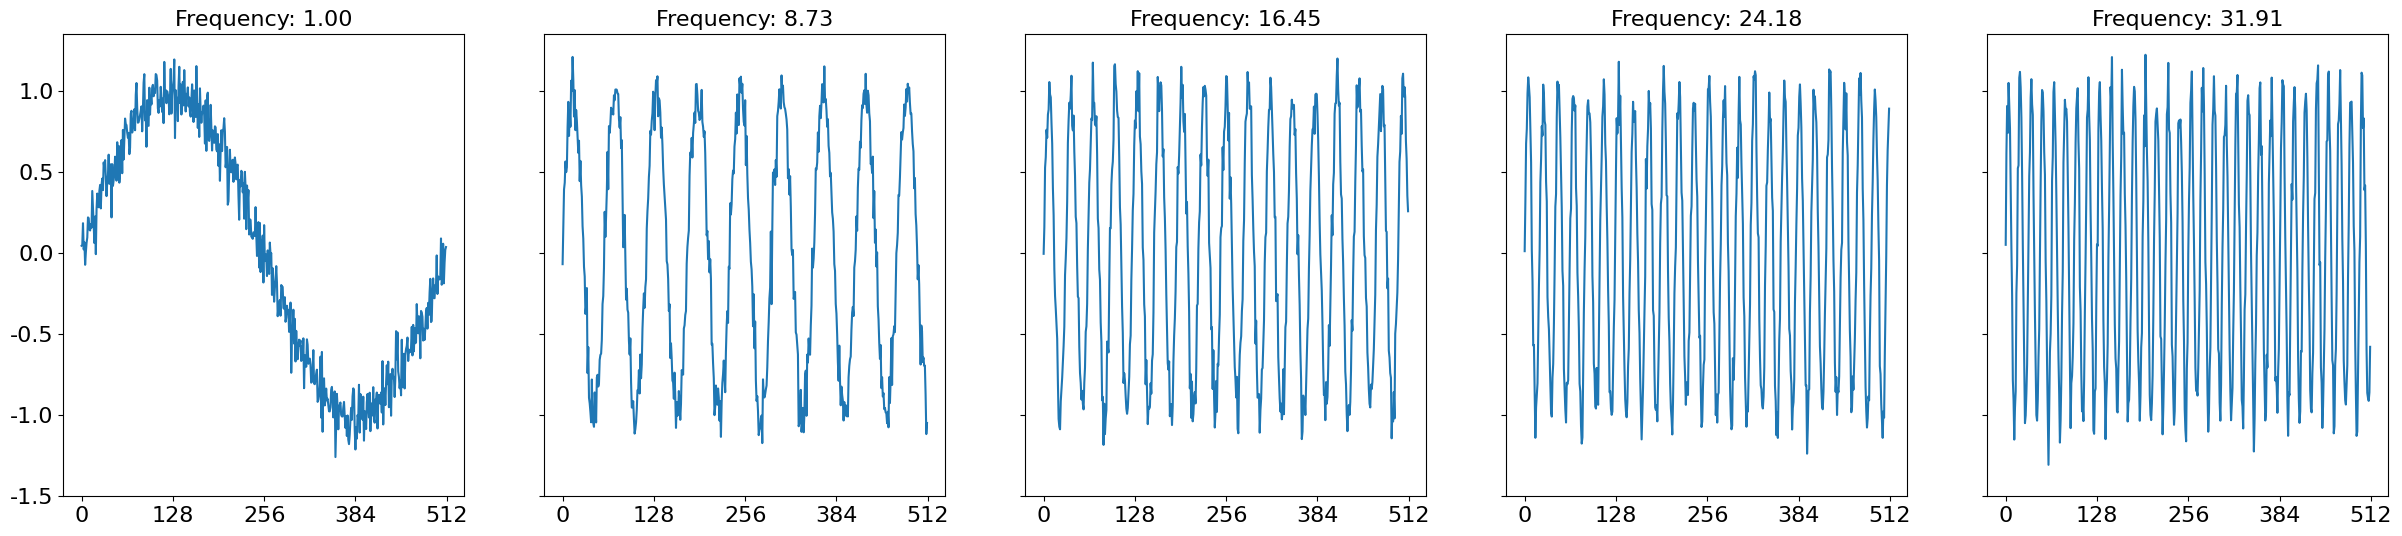

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Frequency: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

Now let's derive embeddings from the model and project them to a 2-dimensional space using Principal Component Analysis (PCA).

In [8]:
from sklearn.decomposition import PCA

model.to("cuda")
model.eval()
y = y.to("cuda")
with torch.no_grad():
    outputs = model(x_enc=y)

# Move tensors and models back to CPU
y = y.detach().cpu().numpy()
embeddings = outputs.embeddings.detach().cpu().numpy()

# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(embeddings)

/home/ppg/miniconda3/envs/moment4ET/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.26.4 and <2.7.0 is required for this version of SciPy (detected version 1.25.2)
  from scipy.sparse import csr_matrix, issparse


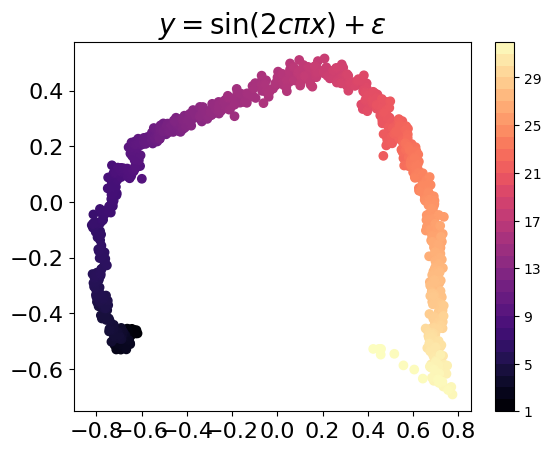

In [9]:
plt.title(f"$y = \sin(2c \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()

### 4.1 Results Interpretation

The first two principal components of the representations learned by MOMENT show some structure. This suggests that the MOMENT may be able to capture subtle changes in the frequency of time series. For more results, refer to Fig. 4 and Fig. 7 in our [paper](https://arxiv.org/abs/2402.03885). 